In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%matplotlib inline

In [2]:
from src.ptp.models.gan_3d.gan3d import Generator
from src.ptp.models.gan_3d.discriminator import Discriminator
from src.ptp.models.gan_3d.gan3d import GAN3D
from src.ptp.models.utils import num_trainable_params
from src.ptp.evaluation.visualization import visualize_slices, visualize_volumes, plot_slice
from src.ptp.models.losses import tce_loss
from pathlib import Path
from lightning.pytorch.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
import nibabel as nib  
import numpy as np

from monai.data import MetaTensor
import pytorch_lightning as pl
import torch
from torch import nn
import os

In [3]:
DATA_DIR = Path('../data/generated_part1_nii_gz')
TARGET_DATA_DIR = DATA_DIR
INPUT_DIR = Path('../data')
MODELS_DIR = INPUT_DIR / 'models'
TRAINING_DIR = INPUT_DIR / 'training'
os.makedirs(TRAINING_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [4]:
percentile = 5
n_critic = 5  # for training more k steps about Discriminator

In [5]:
gan = GAN3D(target_data_dir=TARGET_DATA_DIR, percentile=percentile, n_critic=n_critic, recon_loss=tce_loss)

In [6]:
print(f"Generator size is {num_trainable_params(gan.G)}")
print(f"Discriminator size is {num_trainable_params(gan.D)}")

Generator size is 587011
Discriminator size is 410096


In [7]:
gan.prepare_data()
train_loader = gan.train_dataloader()

Target stats: (0.05283398756942859, -1.0, 1.0)
Image stats: (0.20991943207516792, -0.9999986290931702, 1.0)


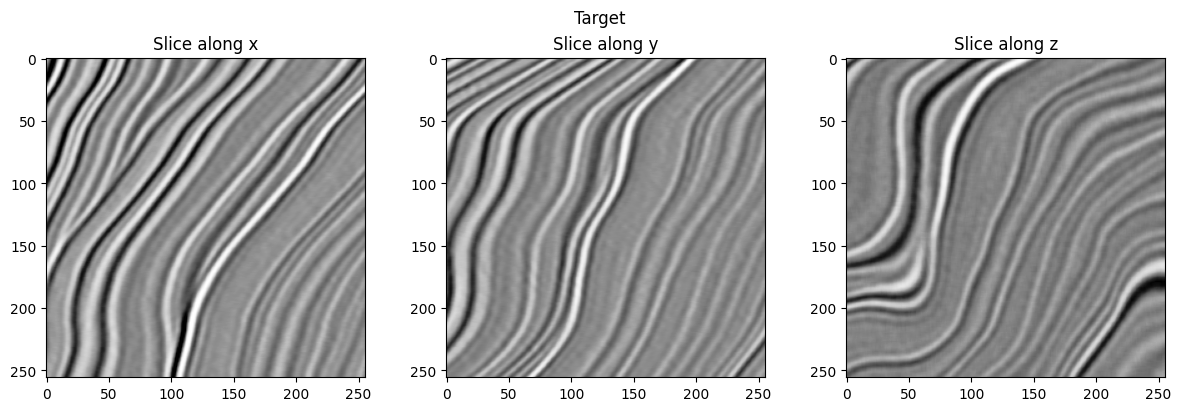

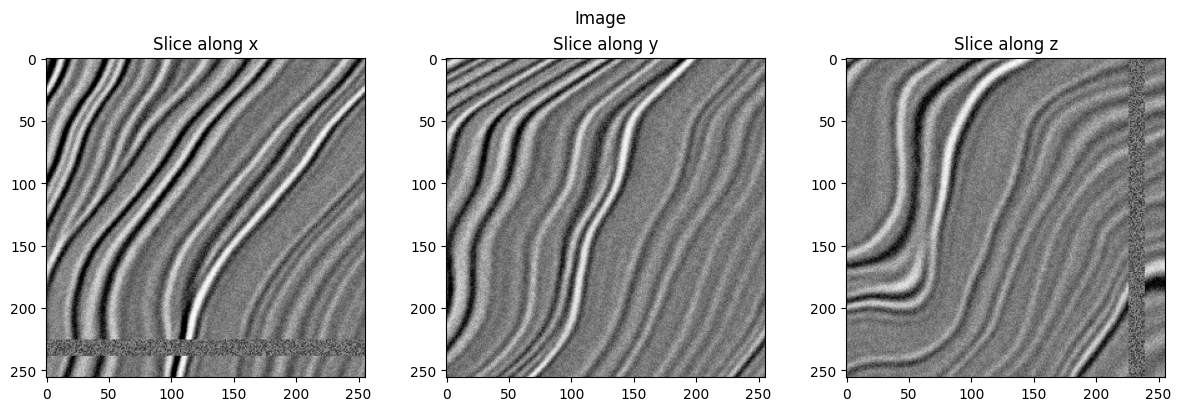

In [8]:
x, y, z = 50, 150, 200
for i, batch in enumerate(train_loader):
    target = nib.Nifti1Image(batch['target'].numpy()[0, 0], np.eye(4))
    image = nib.Nifti1Image(batch['image'].numpy()[0, 0], np.eye(4))
    plot_slice(target, x, y, z, f'Target')
    plot_slice(image, x, y, z, f'Image')
    
    print(f'Target stats: {np.mean(target.get_fdata()), np.min(target.get_fdata()), np.max(target.get_fdata())}')
    print(f'Image stats: {np.mean(image.get_fdata()), np.min(image.get_fdata()), np.max(image.get_fdata())}')

In [13]:
model_name = 'W-3DGAN-tce-loss'

In [14]:
logger = TensorBoardLogger("tb_logs", name=model_name)

In [15]:
max_epochs = 20

checkpoint_dir = TRAINING_DIR / model_name

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir=checkpoint_dir,
    callbacks=[checkpoint_callback],
    fast_dev_run=False,
    logger=logger
)

trainer.fit(gan)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | G    | Generator     | 587 K  | train
1 | D    | Discriminator | 410 K  | train
-----------------------------------------------
997 K     Trainable params
0         Non-trainable params
997 K     Total params
3.988     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  0.25it/s]torch.Size([1, 1, 1, 256, 256, 256])


C:\Users\julia\anaconda3\envs\ptp2\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 1/1 [00:36<00:00,  0.03it/s, v_num=0, d_loss_step=0.00317, n_step_step=1.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s]torch.Size([1, 1, 1, 256, 256, 256])

Epoch 1: 100%|██████████| 1/1 [00:37<00:00,  0.03it/s, v_num=0, d_loss_step=0.00307, n_step_step=2.000, val_g_loss=-0.435, val_d_loss=-1.2e-6, val_loss=-0.435, d_loss_epoch=0.00317, n_step_epoch=1.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s]torch.Size([1, 1, 1, 256, 256, 256])

Epoch 2: 100%|██████████| 1/1 [00:38<00:00,  0.03it/s, v_num=0, d_loss_step=0.00253, n_step_step=3.000, val_g_loss=-0.384, val_d_loss=2.63e-5, val_loss=-0.384, d_loss_epoch=0.00307, n_step_epoch=2.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s]torch.Size([1, 1, 1, 256, 256, 256])

Epoch 3: 100%|██████████| 1/1 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [01:19<00:00,  0.01it/s, v_num=0, d_loss_step=-0.00426, n_step_step=20.00, val_g_loss=-0.434, val_d_loss=-0.00264, val_loss=-0.437, d_loss_epoch=-0.00426, n_step_epoch=20.00, g_loss_step=-0.994, g_loss_epoch=-0.994]


In [33]:
%tensorboard --port 6007 --logdir tb_logs

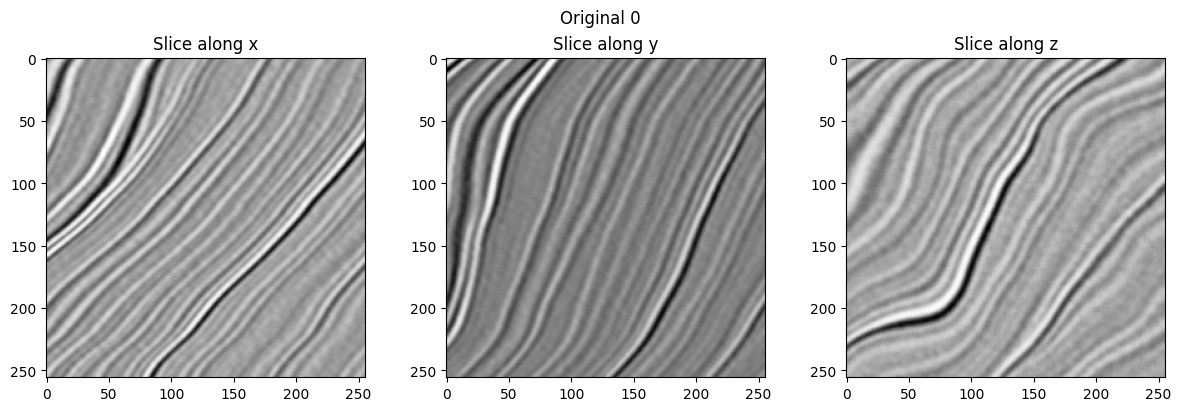

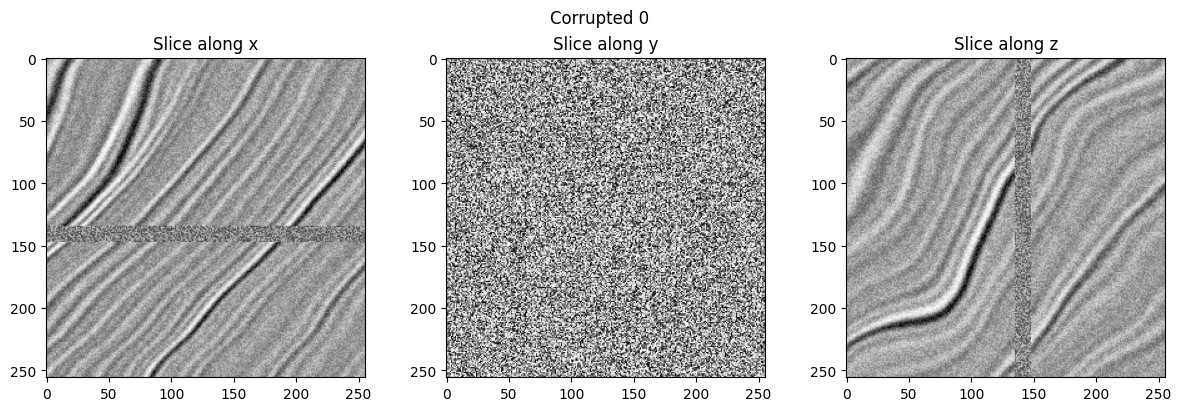

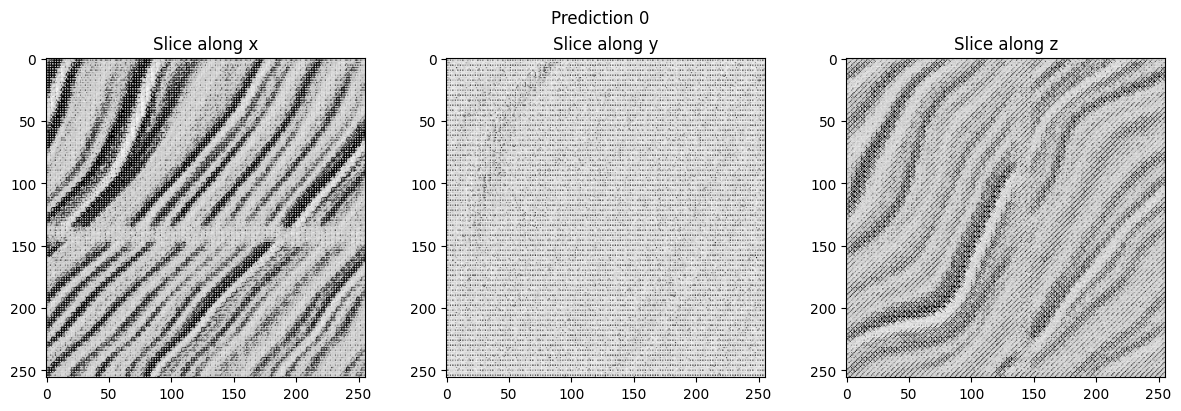

In [28]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

train_loader = gan.train_dataloader()

for i, batch in enumerate(train_loader):
    prediction = gan(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)

In [25]:
batch['prediction'][0, 0, 100, 200, :100]

metatensor([ 0.1232,  0.4512, -0.0545, -0.0299, -0.0153,  0.5086,  0.2266,  0.2581,
         0.2815, -0.0236, -0.0193, -0.0356,  0.3347,  0.6598, -0.0294,  0.0849,
         0.4867, -0.0268,  0.4041, -0.0533,  0.1605,  0.4454, -0.0483, -0.0153,
         0.6408,  0.3191,  0.6822,  0.2773,  0.1334,  0.1809,  0.3704, -0.0446,
         0.1346,  0.2120,  0.0097, -0.0512,  0.3365,  0.4729,  0.0080, -0.0195,
         0.3400,  0.3514,  0.5120,  0.3196, -0.0377, -0.0493, -0.1514, -0.0237,
        -0.0255, -0.0073, -0.0375,  0.0146, -0.0134,  0.3719, -0.1159, -0.0359,
         0.6766,  0.7038, -0.0733,  0.2827,  0.5584,  0.1310, -0.0234,  0.0390,
         0.5551, -0.0363, -0.0587, -0.0754, -0.0612,  0.3053, -0.0351, -0.0596,
         0.5310,  0.5795,  0.6373,  0.1135,  0.6028, -0.0226, -0.0495,  0.2639,
         0.6191,  0.4445,  0.3307,  0.0969, -0.0577,  0.0200,  0.1707, -0.0587,
         0.1677, -0.0343, -0.0795, -0.1230, -0.0022, -0.0037,  0.3805, -0.0270,
        -0.0322,  0.4180,  0.2125,  

In [26]:
batch['prediction'].min()

metatensor(-0.9581, grad_fn=<AliasBackward0>)

In [27]:
batch['image'].min()

metatensor(-1.0000)

In [24]:
batch['image'][0, 0, 100, 200, :100]

metatensor([0.3937, 0.2426, 0.3454, 0.2002, 0.1309, 0.1736, 0.0628, 0.1254, 0.0837,
        0.1314, 0.1109, 0.1931, 0.2831, 0.1181, 0.2116, 0.1711, 0.2414, 0.0320,
        0.1632, 0.1357, 0.2013, 0.2329, 0.2975, 0.1179, 0.2783, 0.0831, 0.0618,
        0.2730, 0.1317, 0.2942, 0.1751, 0.1068, 0.1257, 0.2291, 0.0928, 0.1894,
        0.1126, 0.1783, 0.1534, 0.1382, 0.2359, 0.2598, 0.2995, 0.1149, 0.3014,
        0.1344, 0.1833, 0.2568, 0.2591, 0.1183, 0.2416, 0.2032, 0.2433, 0.2261,
        0.2963, 0.0930, 0.2537, 0.3426, 0.2034, 0.3193, 0.1220, 0.3590, 0.1648,
        0.2787, 0.0659, 0.0963, 0.1905, 0.1415, 0.1465, 0.0452, 0.1036, 0.2026,
        0.1727, 0.3431, 0.0973, 0.0948, 0.2022, 0.0608, 0.2898, 0.1088, 0.3009,
        0.2408, 0.2906, 0.0777, 0.2275, 0.2661, 0.2023, 0.2164, 0.2627, 0.2011,
        0.1754, 0.1551, 0.3418, 0.1580, 0.2462, 0.2779, 0.0886, 0.3295, 0.3135,
        0.1116])